# Introduction:

Given the availability of a large volume of online review data (Amazon, IMDB, etc.), sentiment analysis becomes increasingly important. In this project, a sentiment classifier is built which evaluates the polarity of a piece of review text belonging to a movie review being either positive or negative.
Also a clustering algorithm is also built clustering the review text into different clusters.

# Dataset:

The IMDB Movie Review Dataset download from kaggle shall be used for this project. The dataset is compiled from a collection of 50,000 reviews from IMDB. The numbers of positive and negative reviews are equal each 25,000 rows. Negative reviews is labelled as "neg" while a positive review is labelled as "pos" in label column. Neutral reviews are not included. The 50,000 reviews are divided evenly into the training and test set.

The dataset is downloaded from https://www.kaggle.com/utathya/imdb-review-dataset

The above dataset also has 50,000 unsup (unlabelled) reviews for clustering.

Every row of dataset is devided into 4 columns : 'type', 'review', 'label', 'file'

# Enviroment:

Language : Python 3

Application : jupyter notebook

Libraries : Scikit, Pandas

In [1]:
#IMPORT ALL NECCESSARY PACKAGES
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation

C:\Users\SATYAM\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import warnings
warnings.filterwarnings("ignore")

Reading the dataset and store dataset in data

In [3]:
data = pd.read_csv("imdb-review-dataset/imdb_master.csv", encoding="ISO-8859-1")

Every row of dataset is devided into 4 columns : 'type', 'review', 'label', 'file'

type : train/test

review : text reviews for a movie

label : neg/pos/unsup

file : file from where it's copied


We have in total of 100,000 rows devided rowwise into:

-> First 50,000 rows for sentiment analysis

   *First 12,500 are test data for "neg" label
   
   *12,500-25,000 are test data for "pos" label
   
   *25,000-37,500 are train data for "neg" label
   
   *37,500-50,000 are train data for "pos" label
   
-> Last 50,000 rows for clustering

In [4]:
data.columns

Index(['Unnamed: 0', 'type', 'review', 'label', 'file'], dtype='object')

In [5]:
data.shape

(100000, 5)

In [6]:
data.head()

,Unnamed: 0,type,review,label,file
0,0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


# Data Preprocessing:

In the Preprocessing phase we do the following in the order below:-

1) Begin by removing the html tags

2) Remove any punctuations or limited set of special characters like , or . or # etc.

3) Check if the word is made up of english letters and is not alpha-numeric

4) Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)

5) Convert the word to lowercase

6) Remove Stopwords

7) Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)

After which we collect the words used to describe positive and negative reviews

In [7]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) 
sno = nltk.stem.SnowballStemmer('english') 

def cleanhtml(sentence): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [8]:
i=0
str1=' '
final_string=[]
all_positive_words=[] 
all_negative_words=[] 
s=''
for sent in data['review'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent) 
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (data['label'].values)[i] == "pos": 
                        all_positive_words.append(s) 
                    if(data['label'].values)[i] == "neg":
                        all_negative_words.append(s) 
                else:
                    continue
            else:
                continue 
    
    str1 = b" ".join(filtered_sentence) 
    
    final_string.append(str1)
    i+=1

In [9]:
data['cleaned_review']=final_string

A new column "cleaned_review" is added to dataset containing review after removing html tags , punc , stopwords and after stemming and lemitization

The dataset is divided into train and test dataset

In [10]:
def posneg(x):
    if x=="neg":
        return 0
    elif x=="pos":
        return 1
    return x

filtered_score = data["label"].map(posneg)
data["score"] = filtered_score

In [11]:
test_data = data[:25000]
train_data = data[25000:50000]

X_train : cleaned review of train dataset

X_test : cleaned review of test dataset

y_train : class label for train dataset

y_test : class label for test dataset

In [12]:
X_train = train_data["cleaned_review"]
y_train = train_data["score"]

X_test = test_data["cleaned_review"]
y_test = test_data["score"]

In [13]:
y_train=y_train.astype('int')
y_test=y_test.astype('int')

# Data Representation:

The cleaned review text in represented in vector format using TF-IDF representation:

In [14]:
#TF_IDF

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
tf_idf_train = tf_idf_vect.fit_transform(X_train.values)
tf_idf_test = tf_idf_vect.transform(X_test.values)

# Naive Bayes:

In [15]:
alpha_range = list(np.arange(1,50,5))
len(alpha_range)

10

we will take different values of alpha and using cross validation find mean accuracy score of 5-fold cross validation.

Plot b/w misclassification error and CV mean score.

In [16]:
from sklearn.naive_bayes import MultinomialNB

alpha_scores=[]

for a in alpha_range:
    clf = MultinomialNB(alpha=a)
    scores = cross_val_score(clf, tf_idf_train, y_train, cv=5, scoring='accuracy')
    alpha_scores.append(scores.mean())
    print(a,scores.mean())

1 0.8301999999999999
6 0.8355599999999999
11 0.8340400000000001
16 0.8324
21 0.8312799999999999
26 0.8299199999999999
31 0.8288400000000001
36 0.82736
41 0.82584
46 0.82452


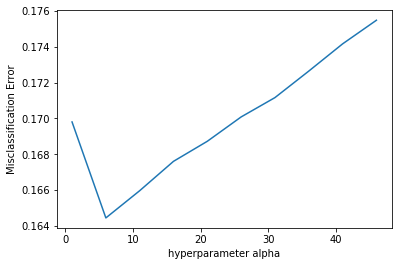

In [17]:
MSE = [1 - x for x in alpha_scores]


optimal_alpha_bnb = alpha_range[MSE.index(min(MSE))]

# plot misclassification error vs alpha
plt.plot(alpha_range, MSE)

plt.xlabel('hyperparameter alpha')
plt.ylabel('Misclassification Error')
plt.show()


In [18]:
optimal_alpha_bnb

6

For alpha = 6 we get minimum missclassification error

Now we will perform following steps:

1) Apply Multinomial Naive Bayes for alpha=6

2) Predict the output using MultinomialNB classifier

3) Find test and train accuracy

4) Plot a confusion matrix and heatmap

5) Find Precision , Recall , F1-Score

In [19]:
clf = MultinomialNB(alpha=6)
clf.fit(tf_idf_train,y_train)

MultinomialNB(alpha=6, class_prior=None, fit_prior=True)

In [20]:
y_pred_test = clf.predict(tf_idf_test)

In [21]:
acc = accuracy_score(y_test, y_pred_test, normalize=True) * float(100)
print('\n****Test accuracy is',(acc))


****Test accuracy is 85.508


In [22]:
cm_test = confusion_matrix(y_test,y_pred_test)
cm_test

array([[11139,  1361],
       [ 2262, 10238]], dtype=int64)

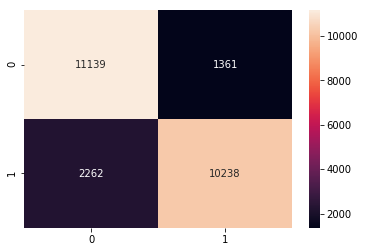

In [23]:
import seaborn as sns
sns.heatmap(cm_test,annot=True,fmt='d')

In [ ]:
#train

In [24]:
y_pred_train = clf.predict(tf_idf_train)

In [25]:
acc = accuracy_score(y_train, y_pred_train, normalize=True) * float(100)
print('\n****Train accuracy is %d%%' % (acc))


****Train accuracy is 93%


In [26]:
cm_train = confusion_matrix(y_train,y_pred_train)
cm_train

array([[11828,   672],
       [  921, 11579]], dtype=int64)

In [7]:
#For test accuracy

In [4]:
tn=11139;fn=1361;fp=2262;tp=10238;
n=tn+fp
p=fn+tp
print("total actual negative points %d"%(n))
print("total actual positive points %d"%(p))

total actual negative points 13401
total actual positive points 11599


In [5]:
tpr=tp/p
tnr=tn/n
fpr=fp/n
fnr=fn/p

print("TPR %f"%(tpr))
print("TNR %f"%(tnr))
print("FPR %f"%(fpr))
print("FNR %f"%(fnr))

TPR 0.882662
TNR 0.831207
FPR 0.168793
FNR 0.117338


In [6]:
precision=tp/(tp+fp)
print("Precision",precision)
recall = tp/p
print("Recall",recall)
f1 = 2*((precision*recall)/(precision+recall))
print("f1-score",f1)

Precision 0.81904
Recall 0.8826622984740063
f1-score 0.8496618116934312


# Feature Selection:

In [27]:
total_positive_words = len(all_positive_words)
total_negative_words = len(all_negative_words)
print(total_positive_words)
print(total_negative_words)

2921958
2846827


In [28]:
type(all_positive_words)

list

In [29]:
import random
apw = random.sample(all_positive_words, 10000)
anw = random.sample(all_negative_words, 10000)

In [30]:
freq_negative_words = {x:anw.count(x) for x in anw}

In [31]:
freq_positive_words = {x:apw.count(x) for x in apw}

In [32]:
lst=[]
for key in freq_positive_words:
    prob = freq_positive_words[key]/total_positive_words
    lst.append([key,prob])
table_positive = pd.DataFrame(lst,columns=['positive_words','probability'])

In [33]:
table_positive = table_positive.sort_values('probability', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')

In [34]:
table_positive.head(10)

,positive_words,probability
24,b'film',0.000060
7,b'movi',0.000050
215,b'one',0.000030
78,b'like',0.000021
73,b'see',0.000019
219,b'great',0.000018
27,b'time',0.000017
30,b'make',0.000017
135,b'stori',0.000016
131,b'would',0.000015


In [48]:
posi={}
i=0
for key, value in sorted(freq_positive_words.items(), key = itemgetter(1), reverse = True):
    if(i>10):
        break
    posi[key]=value
    i+=1
posi

{b'film': 175,
 b'movi': 147,
 b'one': 88,
 b'like': 61,
 b'see': 56,
 b'great': 54,
 b'time': 50,
 b'make': 49,
 b'stori': 47,
 b'even': 44,
 b'first': 44}

In [49]:
lst=[]
for key in freq_negative_words:
    prob = freq_negative_words[key]/total_negative_words
    lst.append([key,prob])
table_negative = pd.DataFrame(lst,columns=['negative_words','probability'])

In [50]:
table_negative = table_negative.sort_values('probability', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')

In [51]:
table_negative.head(10)

,negative_words,probability
41,b'movi',0.000070
34,b'film',0.000054
74,b'one',0.000033
12,b'like',0.000032
107,b'even',0.000021
62,b'bad',0.000019
13,b'good',0.000019
288,b'would',0.000018
229,b'charact',0.000018
469,b'see',0.000017


In [52]:
nega={}
i=0
for key, value in sorted(freq_negative_words.items(), key = itemgetter(1), reverse = True):
    if(i>10):
        break
    nega[key]=value
    i+=1
nega

{b'movi': 199,
 b'film': 154,
 b'one': 93,
 b'like': 92,
 b'even': 59,
 b'bad': 55,
 b'good': 54,
 b'charact': 50,
 b'would': 50,
 b'see': 48,
 b'make': 46}

BARPLOT FOR most frequent negative words


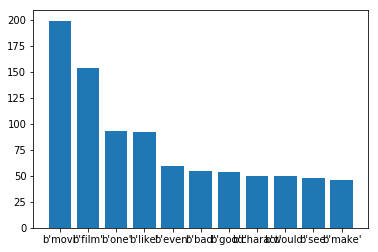

In [61]:
plt.bar(range(len(nega)), list(nega.values()), align='center')
plt.xticks(range(len(nega)), list(nega.keys()))

print("BARPLOT FOR most frequent negative words")
plt.show()

BARPLOT FOR most frequent positive words


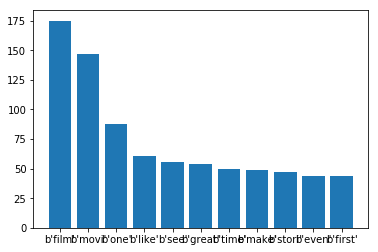

In [62]:
plt.bar(range(len(posi)), list(posi.values()), align='center')
plt.xticks(range(len(posi)), list(posi.keys()))

print("BARPLOT FOR most frequent positive words")
plt.show()

# Clustering:

Clustering analysis is the task of grouping a set of objects in such a way that objects in the same group (called a cluster) are more similar (in some sense or another) to each other than to those in other groups (clusters). 

In [16]:
from sklearn.cluster import KMeans

In [17]:
data_clus = data[50000:]

In [24]:
data_clustering = data_clus.sample(frac=0.2)
data_clustering.shape

(10000, 7)

In [25]:
count_vect = CountVectorizer()
bow = count_vect.fit_transform(data_clustering["review"].values)

In [26]:
bow.shape

(10000, 53408)

k-means Clustering : This technique is more frequently used in analytics industry as it is able to handle large number of data points. FASTCLUS is an algorithm used by SAS to generate k-means cluster. Lets try to analyze how it works

-> Arbitrarly choose k-objects as initial centers

-> Assign each object to most similar centers

-> Update cluster means

-> Reassign

Try this for various values of k (number of clusters) and plot a elbow/knee plot b/w cluster inertia vs number of clusters

In [30]:
cluster_range = range(2,6)

num of clusters: 2 inertia : 4399725.79379872


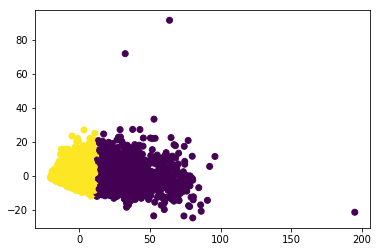


num of clusters: 3 inertia : 3946480.2479156987


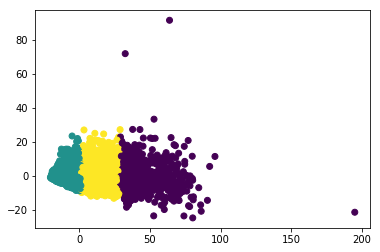


num of clusters: 4 inertia : 3783408.2064712048


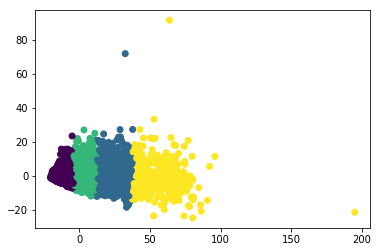


num of clusters: 5 inertia : 3693651.7810727474


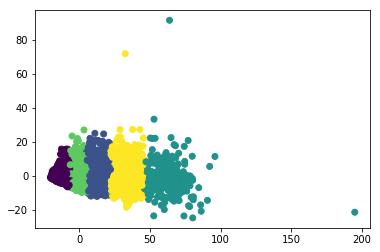

In [31]:
cluster_errors = []

for num_clusters in cluster_range:
    clusters = KMeans(num_clusters)
    clusters.fit(bow)
    cluster_errors.append( clusters.inertia_ )
    print("num of clusters:",num_clusters,"inertia :",clusters.inertia_)
    pl.scatter(pca_2d[:, 0], pca_2d[:, 1], c=clusters.labels_)
    pl.show()
    print()

Plot k vs cluster error

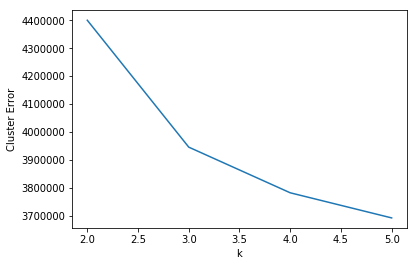

In [32]:
plt.plot(cluster_range, cluster_errors)

plt.xlabel('k')
plt.ylabel('Cluster Error')
plt.show()

In [33]:
kmeans = KMeans(n_clusters=3,n_init=10,n_jobs=-1).fit(bow)
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [27]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pylab as pl

In [28]:
bow_d = bow.todense()

In [29]:
pca = PCA(n_components=2).fit(bow_d)
pca_2d = pca.transform(bow_d)

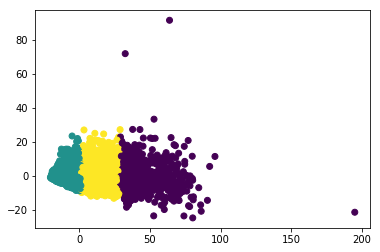

In [34]:
pl.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmeans.labels_)
pl.show()

In [102]:
list0=[]
list1=[]
list2=[]

i=0
for x in kmeans.labels_:
    if(x==0):
        list0.append(data_clustering["review"].iloc[i])
    elif(x==1):
        list1.append(data_clustering["review"].iloc[i])
    elif(x==2):
        list2.append(data_clustering["review"].iloc[i])
    i+=1

In [103]:
from operator import *
stop.add("/><br")

In [104]:
wordcount = {}
for line in list0:
    for word in line.lower().split():
        if word not in stop:
            if word not in wordcount:
                wordcount[word]=1
            else:
                wordcount[word]+=1
dic0={}
i=0
for key, value in sorted(wordcount.items(), key = itemgetter(1), reverse = True):
    if(i>10):
        break
    dic0[key]=value
    i+=1

In [105]:
wordcount = {}
for line in list1:
    for word in line.lower().split():
        if word not in stop:
            if word not in wordcount:
                wordcount[word]=1
            else:
                wordcount[word]+=1
dic1={}
i=0
for key, value in sorted(wordcount.items(), key = itemgetter(1), reverse = True):
    if(i>10):
        break
    dic1[key]=value
    i+=1

In [106]:
wordcount = {}
for line in list2:
    for word in line.lower().split():
        if word not in stop:
            if word not in wordcount:
                wordcount[word]=1
            else:
                wordcount[word]+=1
dic2={}
i=0
for key, value in sorted(wordcount.items(), key = itemgetter(1), reverse = True):
    if(i>10):
        break
    dic2[key]=value
    i+=1

In [107]:
print("cluster 1: ",dic0)
print()
print("cluster 2: ",dic1)
print()
print("cluster 3: ",dic2)

cluster 1:  {'get': 647, 'much': 639, 'time': 624, 'good': 610, 'first': 608, 'two': 579, 'make': 573, 'story': 558, 'people': 516, 'never': 482, 'many': 449}

cluster 2:  {'good': 2467, 'great': 1755, 'get': 1680, 'much': 1582, 'story': 1559, 'bad': 1505, 'people': 1469, 'make': 1469, 'first': 1469, 'time': 1437, 'watch': 1373}

cluster 3:  {'good': 1608, 'much': 1292, 'story': 1288, 'get': 1268, 'first': 1207, 'people': 1118, 'make': 1067, 'time': 1034, 'great': 997, 'made': 989, 'two': 973}
